<a href="https://colab.research.google.com/github/desaigeet96/DL_Assignments/blob/main/DL_Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [3]:
data = pd.read_csv(csv_path)
data = data[5::6]

date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
wv = data['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = data['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
data['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

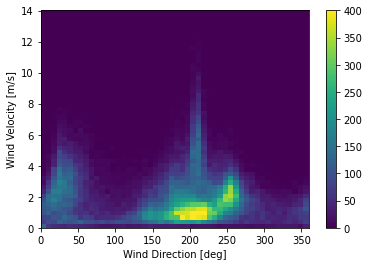

In [6]:
plt.hist2d(data['wd (deg)'], data['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [7]:
wv = data.pop('wv (m/s)')
max_wv = data.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = data.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
data['Wx'] = wv*np.cos(wd_rad)
data['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
data['max Wx'] = max_wv*np.cos(wd_rad)
data['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

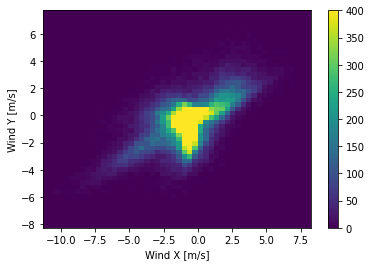

In [8]:
plt.hist2d(data['Wx'], data['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [9]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [10]:
day = 24*60*60
year = (365.2425)*day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

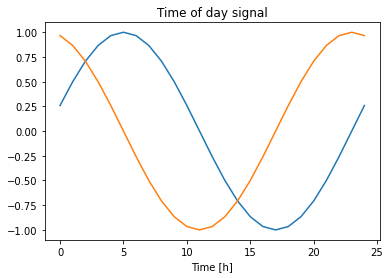

In [11]:
plt.plot(np.array(data['Day sin'])[:25])
plt.plot(np.array(data['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

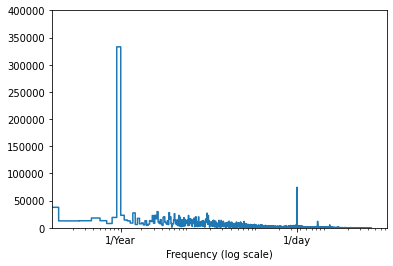

In [12]:
fft = tf.signal.rfft(data['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(data['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [13]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]

Normalizing the data

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

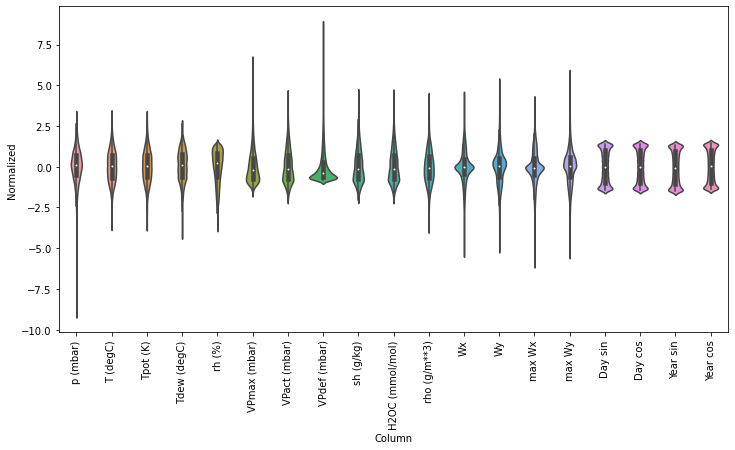

In [15]:
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

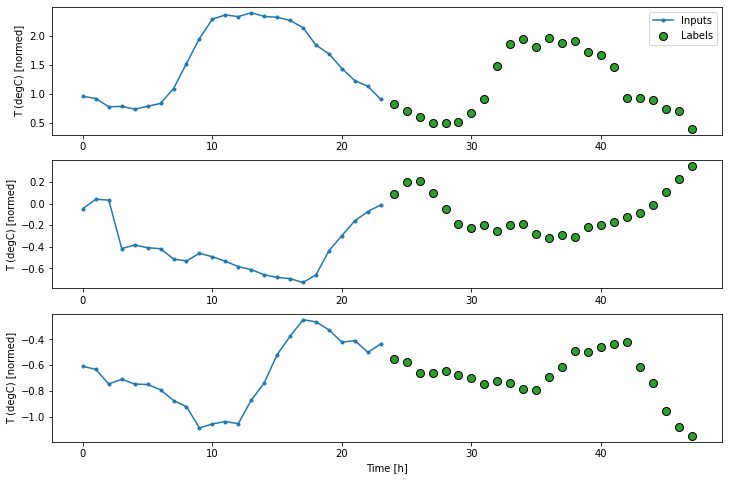

In [22]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [23]:
ms_lstm = tf.keras.Sequential([
                               tf.keras.layers.LSTM(32, return_sequences=False),
                               tf.keras.layers.Dense(OUT_STEPS*num_features),
                               tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_lstm = compile_and_fit(ms_lstm, multi_window )

Epoch 1/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.2927 - mean_absolute_error: 0.3637 - val_loss: 0.2314 - val_mean_absolute_error: 0.3069
Epoch 2/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.2170 - mean_absolute_error: 0.2938 - val_loss: 0.2215 - val_mean_absolute_error: 0.2946
Epoch 3/20
1532/1532 [==============================] - 10s 6ms/step - loss: 0.2092 - mean_absolute_error: 0.2850 - val_loss: 0.2164 - val_mean_absolute_error: 0.2883
Epoch 4/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.2053 - mean_absolute_error: 0.2807 - val_loss: 0.2184 - val_mean_absolute_error: 0.2893
Epoch 5/20
1532/1532 [==============================] - 10s 6ms/step - loss: 0.2025 - mean_absolute_error: 0.2779 - val_loss: 0.2143 - val_mean_absolute_error: 0.2857
Epoch 6/20
1532/1532 [==============================] - 10s 6ms/step - loss: 0.2006 - mean_absolute_error: 0.2761 - val_loss: 0.2168 - val_mean_absolute_error: 0.287

In [24]:
ms_rnn  = tf.keras.Sequential([
                               tf.keras.layers.SimpleRNN(32, return_sequences=False),
                               tf.keras.layers.Dense(OUT_STEPS*num_features),
                               tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_rnn = compile_and_fit(ms_rnn, multi_window )

Epoch 1/20
1532/1532 [==============================] - 29s 19ms/step - loss: 0.2931 - mean_absolute_error: 0.3644 - val_loss: 0.2450 - val_mean_absolute_error: 0.3187
Epoch 2/20
1532/1532 [==============================] - 29s 19ms/step - loss: 0.2330 - mean_absolute_error: 0.3065 - val_loss: 0.2324 - val_mean_absolute_error: 0.3020
Epoch 3/20
1532/1532 [==============================] - 28s 18ms/step - loss: 0.2246 - mean_absolute_error: 0.2960 - val_loss: 0.2275 - val_mean_absolute_error: 0.2968
Epoch 4/20
1532/1532 [==============================] - 29s 19ms/step - loss: 0.2208 - mean_absolute_error: 0.2918 - val_loss: 0.2255 - val_mean_absolute_error: 0.2949
Epoch 5/20
1532/1532 [==============================] - 28s 18ms/step - loss: 0.2187 - mean_absolute_error: 0.2894 - val_loss: 0.2230 - val_mean_absolute_error: 0.2920
Epoch 6/20
1532/1532 [==============================] - 28s 18ms/step - loss: 0.2170 - mean_absolute_error: 0.2876 - val_loss: 0.2214 - val_mean_absolute_error:

In [25]:
ms_gru  = tf.keras.Sequential([
                               tf.keras.layers.GRU(32, return_sequences=False),
                               tf.keras.layers.Dense(OUT_STEPS*num_features),
                               tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_gru = compile_and_fit(ms_gru, multi_window )

Epoch 1/20
1532/1532 [==============================] - 77s 50ms/step - loss: 0.2802 - mean_absolute_error: 0.3533 - val_loss: 0.2286 - val_mean_absolute_error: 0.3033
Epoch 2/20
1532/1532 [==============================] - 75s 49ms/step - loss: 0.2178 - mean_absolute_error: 0.2932 - val_loss: 0.2206 - val_mean_absolute_error: 0.2933
Epoch 3/20
1532/1532 [==============================] - 78s 51ms/step - loss: 0.2107 - mean_absolute_error: 0.2855 - val_loss: 0.2180 - val_mean_absolute_error: 0.2896
Epoch 4/20
1532/1532 [==============================] - 82s 53ms/step - loss: 0.2071 - mean_absolute_error: 0.2818 - val_loss: 0.2172 - val_mean_absolute_error: 0.2883
Epoch 5/20
1532/1532 [==============================] - 81s 53ms/step - loss: 0.2046 - mean_absolute_error: 0.2797 - val_loss: 0.2165 - val_mean_absolute_error: 0.2881
Epoch 6/20
1532/1532 [==============================] - 80s 52ms/step - loss: 0.2027 - mean_absolute_error: 0.2781 - val_loss: 0.2142 - val_mean_absolute_error: